In [1]:
import sys
sys.path.append("../../SiMaC/")

In [23]:
import os
import string

import torch
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score

from src.dataset.toy import ToyDataset
from src.ml.model import ModelOT
from src.ml.layers import ScaledEmbedding
from src.ml.sinkhorn import SinkhornLoss, sinkhorn
from src.ml.train import assign_with_lap
from src import viz

In [3]:
sns.set(style="whitegrid", palette="Set2", font_scale=1.3)

In [4]:
%load_ext autoreload

In [5]:
FIG_SAVE_PATH = os.path.join("..", "paper", "figures")

In [6]:
%autoreload 2

## Dataset

In [7]:
n_centers = 3
n_items = 3
n_users = 1000
distance_weight = 0.3
n_features = 2

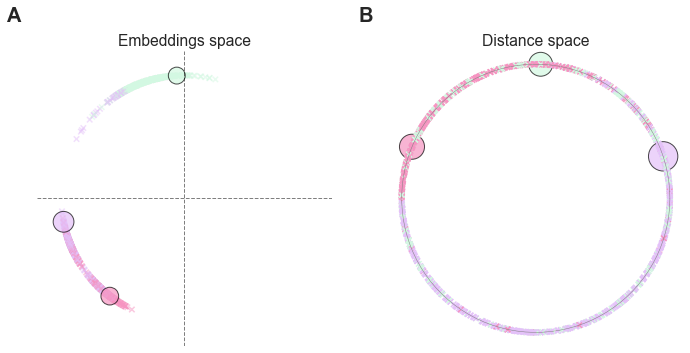

In [11]:
toy = ToyDataset(
    n_centers=n_centers,
    n_items=n_items,
    n_users=n_users,
    n_features=n_features,
    distance_weight=distance_weight
)

fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)

# Embeddings space
viz.plot_embeddings(
    users_features=torch.from_numpy(toy.users_features),
    items_features=torch.from_numpy(toy.items_features),
    items_capacities=toy.items_capacities,
    y_pred=toy.assigned_item_for_user,
    ax=axs[0]
)

# Distance space
viz.plot_distances(
    np.asarray(list(zip(toy.users_x, toy.users_y))),
    np.asarray(list(zip(toy.items_x, toy.items_y))),
    toy.circle_radius,
    toy.assigned_item_for_user,
    toy.items_capacities,
    axs[1]
)

axs[0].set_title("Embeddings space")
axs[1].set_title("Distance space")

# Annotate with letters
for i in range(2):
    axs[i].text(-0.1, 1.1, string.ascii_uppercase[i],
                transform=axs[i].transAxes, 
                size=20, weight="bold")

plt.tight_layout()
plt.show()

## Model

In [12]:
class ModelOT(torch.nn.Module):
    def __init__(self, capacities, n_users, epsilon, alpha,
                 n_features, n_iter=10, user_embeddings=None,
                 train_user_embeddings=False):
        super(ModelOT, self).__init__()
        self.capacities = torch.FloatTensor(capacities)
        self.epsilon = epsilon
        self.alpha = alpha
        self.n_iter = n_iter

        self.item_embeddings = ScaledEmbedding(
            num_embeddings=capacities.shape[1],
            embedding_dim=n_features,
        )

        self.user_embeddings = ScaledEmbedding(
            num_embeddings=n_users,
            embedding_dim=n_features,
            _weight=user_embeddings
        )
        self.user_embeddings.weight.requires_grad = train_user_embeddings

    def forward(self, users_tensor, items_tensor, D_tensor):
        """Run the forward pass

        Args:
            users_tensor (torch.LongTensor): User ids
            items_tensor (torch.LongTensor): Item ids
            D_tensor (torch.FloatTensor): Travel distance matrix

        Returns:
            torch.FloatTensor: Probability allocation matrix
        """

        # Size variables
        batch_size = users_tensor.shape[0]
        n_candidates = items_tensor.shape[1]
        n_users = self.user_embeddings.weight.shape[0]

        # Embedding lookup
        item_embeddings = self.item_embeddings(items_tensor)
        user_embeddings = self.user_embeddings(users_tensor)

        # Dot products
        dot_products = torch.bmm(
            item_embeddings,
            user_embeddings.view(batch_size, user_embeddings.shape[1], 1)
        )
        dot_products = dot_products.view(batch_size, n_candidates)

        # Affinity matrix
        affinity_matrix = (1-self.alpha) * dot_products \
                           -self.alpha * (D_tensor / torch.mean(D_tensor))
        
        return affinity_matrix

## Training

In [13]:
target = torch.nn.functional.one_hot(
    torch.tensor(toy.assigned_item_for_user),
    num_classes=toy.n_items
)

In [27]:
# define model, loss & optimizer
model = ModelOT(
    capacities=toy.items_capacities,
    n_users=toy.n_users,
    epsilon=0.1,
    alpha=0.2,
    n_iter=10,
    n_features=n_features,
    user_embeddings=torch.FloatTensor(toy.users_features),
    train_user_embeddings=False
)

sinkhorn_loss = SinkhornLoss(
    a=torch.ones(toy.n_users),
    b=torch.FloatTensor(toy.items_capacities).view(-1),
    epsilon=0.1, 
    solver=sinkhorn,
    n_iter=100
)

optimizer = torch.optim.Adam(lr=0.05, params=model.parameters())

# actual training
model.train()

for epoch in range(50):
    train_epoch_loss = 0
    optimizer.zero_grad()

    # Model out
    M = model(toy.users_tensor, toy.items_tensor, toy.D_tensor)
    
    # Loss
    loss = sinkhorn_loss(M, target)
    loss.backward()
    optimizer.step()
    
    # Predictions
    y_pred = assign_with_lap(M, toy.items_capacities)
    f1 = f1_score(y_true=toy.y_true_tensor, y_pred=y_pred, average="macro")
    
    # Print stats
    print("Epoch {0}: loss={1:3f}, F1={2:.3f}".format(epoch+1, loss.item(), f1))

Epoch 1: loss=4164.722168, F1=0.312
Epoch 2: loss=3558.269043, F1=0.319
Epoch 3: loss=2789.697510, F1=0.408
Epoch 4: loss=2024.669922, F1=0.520
Epoch 5: loss=1329.829956, F1=0.627
Epoch 6: loss=878.426514, F1=0.757
Epoch 7: loss=646.838928, F1=0.820
Epoch 8: loss=502.787933, F1=0.855
Epoch 9: loss=405.437134, F1=0.894
Epoch 10: loss=338.128387, F1=0.913
Epoch 11: loss=282.369019, F1=0.918
Epoch 12: loss=233.397217, F1=0.933
Epoch 13: loss=189.684341, F1=0.940
Epoch 14: loss=151.548996, F1=0.949
Epoch 15: loss=119.744423, F1=0.953
Epoch 16: loss=94.863525, F1=0.957
Epoch 17: loss=77.456970, F1=0.971
Epoch 18: loss=67.612122, F1=0.981
Epoch 19: loss=64.535973, F1=0.981
Epoch 20: loss=66.230850, F1=0.977
Epoch 21: loss=70.244965, F1=0.965
Epoch 22: loss=74.474136, F1=0.957
Epoch 23: loss=77.470558, F1=0.954
Epoch 24: loss=78.488106, F1=0.952
Epoch 25: loss=77.418396, F1=0.957
Epoch 26: loss=74.657654, F1=0.959
Epoch 27: loss=70.933289, F1=0.965
Epoch 28: loss=67.125046, F1=0.973
Epoch 29: